In [129]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
sns.set()

from scipy.stats import probplot, boxcox
from scipy.special import inv_boxcox
import pylab

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.linear_model import Ridge, Lasso, BayesianRidge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from catboost import CatBoostRegressor
# from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

from sklearn.metrics import mean_squared_error, r2_score

import tensorflow as tf

pd.options.mode.chained_assignment = None  # temporarily suppress the warning

### Importing Data

In [130]:
import pandas as pd
from sqlalchemy import create_engine
from urllib.parse import quote


def load_data_from_postgres():
    # Database credentials
    POSTGRES_DB="nsrentals"
    POSTGRES_USER="blackholes"
    POSTGRES_PORT="5432"
    RAW_PASSWORD="Blackholes@7007"
    POSTGRES_SERVER_HOST="54.196.154.157"
    POSTGRES_PASSWORD = quote(RAW_PASSWORD)
    
    # Creating a connection URL
    connection_string = f"postgresql://{POSTGRES_USER}:{POSTGRES_PASSWORD}@{POSTGRES_SERVER_HOST}:{POSTGRES_PORT}/{POSTGRES_DB}"
    
    # Create the engine
    engine = create_engine(connection_string)
    
    # SQL query to load data
    query = "SELECT * FROM sec_public_rental_data"
    
    # Load data into a DataFrame
    df = pd.read_sql(query, engine)
    
    # Make sure to close the connection
    engine.dispose()
    
    return df



data = load_data_from_postgres()

In [131]:
data.head(10)

id                       listing_name                      building_name  \
0    1            The Cliffs at Dellridge            The Cliffs at Dellridge   
1    2                        Lotus Point                        Lotus Point   
2    3           Park Victoria Apartments           Park Victoria Apartments   
3    4           Park Victoria Apartments           Park Victoria Apartments   
4    5   NEW BUILD - 2 Bedroom Lower Flat   NEW BUILD - 2 Bedroom Lower Flat   
5    6               19 Twenty Apartments               19 Twenty Apartments   
6    7               19 Twenty Apartments               19 Twenty Apartments   
7    8               19 Twenty Apartments               19 Twenty Apartments   
8  316                 Apartment for rent                                 -1   
9    9  Halifax Apartments – Scotia Tower  Halifax Apartments – Scotia Tower   

  apartment_number                                            address  \
0               -1   81 Dellridge Ln , Bedford , NS B4A 4H6 – Bedford   
1               -1  103 Ochterloney St , Dartmouth , NS B2Y 1C6 – ...   
2               -1  1333 South Park St , Halifax , NS B3J 2K9 – Ha...   
3               -1  1333 South Park St , Halifax , NS B3J 2K9 – Ha...   
4               -1    29 McIntosh St , Halifax , NS B3R 1G9 – Halifax   
5               -1  1920 Brunswick St , Halifax , NS B3J 0C5 – Hal...   
6               -1  1920 Brunswick St , Halifax , NS B3J 0C5 – Hal...   
7               -1  1920 Brunswick St , Halifax , NS B3J 0C5 – Hal...   
8               -1              5515 Clyde St #0, Halifax, NS B3J 0K2   
9               -1  1991 Brunswick St , Halifax , NS B3J 2G9 – Hal...   

     add_lat   add_long                           property_management_name  \
0  44.700960 -63.690029  https://images1.apartments.com/i2/x1vMq99BZins...   
1  44.668397 -63.566526  https://images1.apartments.com/i2/CZpkA37fh4ax...   
2  44.640570 -63.578214  https://images1.apartments.com/i2/CVV1klyaKFdp...   
3  44.640570 -63.578214  https://images1.apartments.com/i2/CVV1klyaKFdp...   
4  44.602531 -63.605486  https://images1.apartments.com/i2/e9XIsg9v-lxR...   
5  44.649648 -63.578481  https://images1.apartments.com/i2/CVV1klyaKFdp...   
6  44.649648 -63.578481  https://images1.apartments.com/i2/CVV1klyaKFdp...   
7  44.649648 -63.578481  https://images1.apartments.com/i2/CVV1klyaKFdp...   
8        NaN        NaN                                                 -1   
9  44.649836 -63.577913  https://images1.apartments.com/i2/CVV1klyaKFdp...   

   monthly_rent property_type  ...  dist_larry_uteck_area  \
0          -1.0     Apartment  ...               0.189857   
1        2750.0     Apartment  ...               6.315913   
2        2110.0     Apartment  ...               6.722169   
3        2640.0     Apartment  ...               6.722169   
4        2250.0     Apartment  ...               7.786871   
5        2029.0     Apartment  ...               6.354436   
6        2200.0     Apartment  ...               6.354436   
7        2725.0     Apartment  ...               6.354436   
8        3000.0            -1  ...              -1.000000   
9        1895.0     Apartment  ...               6.371136   

   dist_central_halifax  dist_clayton_park  dist_rockingham  \
0              5.025187           3.542774         2.925166   
1              2.867053           3.966552         3.878464   
2              2.060543           3.617263         3.993752   
3              2.060543           3.617263         3.993752   
4              3.289756           4.464459         5.265877   
5              1.957188           3.417876         3.662356   
6              1.957188           3.417876         3.662356   
7              1.957188           3.417876         3.662356   
8             -1.000000          -1.000000        -1.000000   
9              1.985364           3.442461         3.681630   

                                              source         website  \
0  https://www.apartme

### EDA

In [132]:
print(f'Number of rows in the dataset: {data.shape[0]}')
print(f'Number of columns in the dataset: {data.shape[1]}')

Number of rows in the dataset: 2275
Number of columns in the dataset: 47


In [133]:
 data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2275 entries, 0 to 2274
Data columns (total 47 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   id                           2275 non-null   int64         
 1   listing_name                 2275 non-null   object        
 2   building_name                2275 non-null   object        
 3   apartment_number             2275 non-null   object        
 4   address                      2275 non-null   object        
 5   add_lat                      2243 non-null   float64       
 6   add_long                     2243 non-null   float64       
 7   property_management_name     2275 non-null   object        
 8   monthly_rent                 2275 non-null   float64       
 9   property_type                2275 non-null   object        
 10  bedroom_count                2275 non-null   int64         
 11  bathroom_count               2275 non-null 

In [134]:
data.describe()

id      add_lat     add_long  monthly_rent  bedroom_count  \
count  2275.000000  2243.000000  2243.000000   2275.000000    2275.000000   
mean   1138.000000    44.579601   -63.391825    721.745055       1.224615   
min       1.000000   -28.011885  -106.346771     -1.000000      -1.000000   
25%     569.500000    44.637828   -63.655811      1.000000       1.000000   
50%    1138.000000    44.644951   -63.596925      1.000000       1.000000   
75%    1706.500000    44.664582   -63.578777   1800.000000       1.000000   
max    2275.000000    56.130366   153.354729   6000.000000       5.000000   
std     656.880253     2.691048     8.090434   1090.419195       0.671777   

       bathroom_count  utility_water  utility_heat  utility_electricity  \
count     2275.000000         2275.0   2275.000000               2275.0   
mean         1.068571           -1.0      0.056264                  0.0   
min         -1.000000           -1.0      0.000000                  0.0   
25%          1.000000           -1.0      0.000000                  0.0   
50%          1.000000           -1.0      0.000000                  0.0   
75%          1.000000           -1.0      0.000000                  0.0   
max          4.000000           -1.0      1.000000                  0.0   
std          0.323040            0.0      0.230481                  0.0   

       utility_laundry  ...  dist_hospital  dist_school  dist_restaurant  \
count      2275.000000  ...    1973.000000  2201.000000      2226.000000   
mean          0.078681  ...       0.657336     0.471831         0.488183   
min           0.000000  ...       0.000000     0.000000         0.001807   
25%           0.000000  ...       0.227827     0.229575         0.202889   
50%           0.000000  ...       0.446836     0.351454         0.377447   
75%           0.000000  ...       0.821288     0.555125         0.567268   
max           1.000000  ...       3.085524     3.070787         3.060123   
std           0.269300  ...       0.626345     0.432529         0.447863   

       dist_downtown  dist_busstop  dist_larry_uteck_area  \
count    2275.000000   2243.000000            2275.000000   
mean       20.078601      0.520036              22.388640   
min        -1.000000      0.000000              -1.000000   
25%         0.697695      0.195273               4.246092   
50%         1.707733      0.434012               6.178628   
75%         4.837441      0.738609               6.926591   
max     10109.401387      2.794327           10103.157776   
std       374.098350      0.410484             373.710913   

       dist_central_halifax  dist_clayton_park  dist_rockingham  \
count           2275.000000        2275.000000      2275.000000   
mean              20.027227          20.508816        20.724628   
min               -1.000000          -1.000000        -1.000000   
25%                1.570893           2.415034         2.544214   
50%                2.221965           3.463688         3.791716   
75%                3.412204           4.079689         4.440268   
max            10107.429282       10105.885523     10105.677442   
std              374.011176         373.919396       373.897082   

                       load_datetime  
count                           2275  
mean   2024-03-25 03:15:02.698503424  
min       2024-03-25 02:33:03.256133  
25%    2024-03-25 03:21:39.438891264  
50%    2024-03-25 03:21:39.570829056  
75%    2024-03-25 03:21:39.693285632  
max       2024-03-25 03:21:39.813716  
std                              NaN  

[8 rows x 32 columns]

In [135]:
## Remove it later

import pandas as pd

# Assuming 'data' is your DataFrame and it indeed has the 'monthly_rent' column
# Filter the DataFrame for rows where monthly_rent is greater than 200
filtered_data = data[data['monthly_rent'] > 200]

# Sample 500 data points from the filtered DataFrame
sampled_data = filtered_data.sample(n=100, random_state=42)  # Adjust random_state as needed

# Append the sampled data back to the original DataFrame using pd.concat
data = pd.concat([data, sampled_data], ignore_index=True)

data

id                                       listing_name  \
0        1                            The Cliffs at Dellridge   
1        2                                        Lotus Point   
2        3                           Park Victoria Apartments   
3        4                           Park Victoria Apartments   
4        5                   NEW BUILD - 2 Bedroom Lower Flat   
...    ...                                                ...   
2370   316                                 Apartment for rent   
2371  1345         LOVELY 1 BEDROOM AVAILABLE IN CLAYTON PARK   
2372    24                          Somerset Place Apartments   
2373  1661  Ocean view new condo with 2 bedrooms + two bat...   
2374  2258                                     3 bdrm, 1 bath   

                         building_name apartment_number  \
0              The Cliffs at Dellridge               -1   
1                          Lotus Point               -1   
2             Park Victoria Apartments               -1   
3             Park Victoria Apartments               -1   
4     NEW BUILD - 2 Bedroom Lower Flat               -1   
...                                ...              ...   
2370                                -1               -1   
2371                                -1               -1   
2372         Somerset Place Apartments               -1   
2373                                -1               -1   
2374                                -1               -1   

                                                address    add_lat   add_long  \
0      81 Dellridge Ln , Bedford , NS B4A 4H6 – Bedford  44.700960 -63.690029   
1     103 Ochterloney St , Dartmouth , NS B2Y 1C6 – ...  44.668397 -63.566526   
2     1333 South Park St , Halifax , NS B3J 2K9 – Ha...  44.640570 -63.578214   
3     1333 South Park St , Halifax , NS B3J 2K9 – Ha...  44.640570 -63.578214   
4       29 McIntosh St , Halifax , NS B3R 1G9 – Halifax  44.602531 -63.605486   
...                                                 ...        ...        ...   
2370              5515 Clyde St #0, Halifax, NS B3J 0K2        NaN        NaN   
2371  85 Westgrove, 241 Willett Street, 235 Willett ...  44.658752 -63.652550   
2372  1030 South Park St , Halifax , NS B3H 2W3 – Ha...  44.635228 -63.576661   
2373                1048 Wellington Street, Halifax, NS  44.634508 -63.579713   
2374                                Halifax, NS B3M 1C2  44.661938 -63.631021   

                               property_management_name  monthly_rent  \
0     https://images1.apartments.com/i2/x1vMq99BZins...          -1.0   
1     https://images1.apartments.com/i2/CZpkA37fh4ax...        2750.0   
2     https://images1.apartments.com/i2/CVV1klyaKFdp...        2110.0   
3     https://images1.apartments.com/i2/CVV1klyaKFdp...        2640.0   
4     https://images1.apartments.com/i2/e9XIsg9v-lxR...        2250.0   
...                                                 ...           ...   
2370                                                 -1        3000.0   
2371                                                 -1        1839.0   
2372  https://images1.apartments.com/i2/CVV1klyaKFdp...        1969.0   
2373                                        Kijiji User        2900.0   
2374                                        Kijiji User        3000.0   

     property_type  ...  dist_larry_uteck_area  dist_central_halifax  \
0        Apartment  ...               0.189857              5.025187   
1        Apartment  ...               6.315913              2.867053   
2        Apartment  ...               6.722169              2.060543   
3        Apartment  ...               6.722169              2.060543   
4        Apartment  ...               7.786871              3.289756   
...            ...  ...                    ...                   ...   
2370            -1  ...              -1.000000             -1.000000   
2371            -1  ...               3.264255              1.815071   
2372     Apartment  

### Data Cleaning

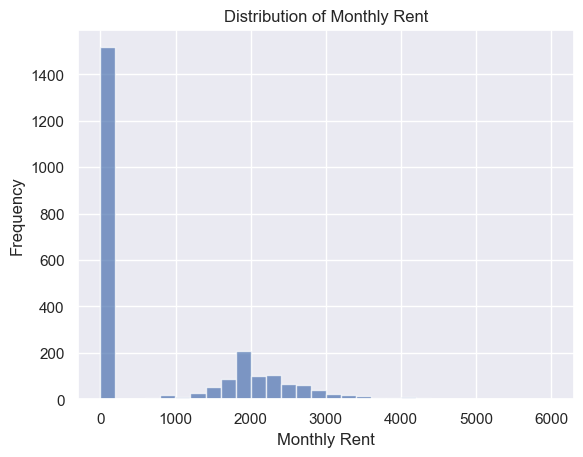

In [136]:
import matplotlib.pyplot as plt

plt.hist(data['monthly_rent'], bins=30, alpha=0.7)
plt.title('Distribution of Monthly Rent')
plt.xlabel('Monthly Rent')
plt.ylabel('Frequency')
plt.show()

In [137]:
# Assuming 'data' is your DataFrame
filtered_data = data[data['monthly_rent'] < 200]

# Display the filtered DataFrame
filtered_data

id                                 listing_name  \
0        1                      The Cliffs at Dellridge   
119    115                                159 Radcliffe   
120    116                                159 Radcliffe   
121    117                                159 Radcliffe   
122    118                                159 Radcliffe   
...    ...                                          ...   
2268  2269    Looking for a room with  private washroom   
2269  2270               3 bedroom house in Terence Bay   
2270  2271                         Looking to buy house   
2271  2272  Furnished bedroom for rent. All incl. $1200   
2273  2274     Buying multifamily real estate buildings   

                building_name apartment_number  \
0     The Cliffs at Dellridge               -1   
119             159 Radcliffe               -1   
120             159 Radcliffe               -1   
121             159 Radcliffe               -1   
122             159 Radcliffe               -1   
...                       ...              ...   
2268                       -1               -1   
2269                       -1               -1   
2270                       -1               -1   
2271                       -1               -1   
2273                       -1               -1   

                                               address    add_lat   add_long  \
0     81 Dellridge Ln , Bedford , NS B4A 4H6 – Bedford  44.700960 -63.690029   
119               159 Radcliffe Drive, Halifax B3M 4K2  44.665555 -63.664874   
120               159 Radcliffe Drive, Halifax B3M 4K2  44.665555 -63.664874   
121               159 Radcliffe Drive, Halifax B3M 4K2  44.665555 -63.664874   
122               159 Radcliffe Drive, Halifax B3M 4K2  44.665555 -63.664874   
...                                                ...        ...        ...   
2268                  1796 Summer St, Halifax, B3H 3A6  44.645789 -63.586385   
2269               Terence Bay Rd, Terence Bay, NS B3T  44.498734 -63.734063   
2270                               Halifax, NS, B3T1R6  44.564682 -63.737797   
2271                  Washmill Lake Drive, Halifax, NS  44.647687 -63.661242   
2273                   1016 Tower Rd, Halifax, B3H 2Y5  44.634137 -63.578225   

                               property_management_name  monthly_rent  \
0     https://images1.apartments.com/i2/x1vMq99BZins...          -1.0   
119                                                  -1           1.0   
120                                                  -1           1.0   
121                                                  -1           1.0   
122                                                  -1           1.0   
...                                                 ...           ...   
2268                                                 -1           1.0   
2269                                                 -1           1.0   
2270                                                 -1           1.0   
2271                                                 -1           1.0   
2273                                                 -1           1.0   

     property_type  ...  dist_larry_uteck_area  dist_central_halifax  \
0        Apartment  ...               0.189857              5.025187   
119             -1  ...               2.559813              2.560102   
120             -1  ...               2.559813              2.560102   
121             -1  ...               2.559813              2.560102   
122             -1  ...               2.559813              2.560102   
...            ...  ...                    ...                   ...   
2268            -1  ...               6.183863              1.586152   
2269            -1  ...              14.017197             11.865815   
2270            -1  ...               9.600637              8.303722   
2271            -1  ...               3.768055              2.125271   
2273            -1  ...               6.997530              2.230972

In [138]:
# Assuming 'data' is your DataFrame
cleaned_data = data[data['monthly_rent'] > 200]

# Display the filtered DataFrame
cleaned_data

id                                       listing_name  \
1        2                                        Lotus Point   
2        3                           Park Victoria Apartments   
3        4                           Park Victoria Apartments   
4        5                   NEW BUILD - 2 Bedroom Lower Flat   
5        6                               19 Twenty Apartments   
...    ...                                                ...   
2370   316                                 Apartment for rent   
2371  1345         LOVELY 1 BEDROOM AVAILABLE IN CLAYTON PARK   
2372    24                          Somerset Place Apartments   
2373  1661  Ocean view new condo with 2 bedrooms + two bat...   
2374  2258                                     3 bdrm, 1 bath   

                         building_name apartment_number  \
1                          Lotus Point               -1   
2             Park Victoria Apartments               -1   
3             Park Victoria Apartments               -1   
4     NEW BUILD - 2 Bedroom Lower Flat               -1   
5                 19 Twenty Apartments               -1   
...                                ...              ...   
2370                                -1               -1   
2371                                -1               -1   
2372         Somerset Place Apartments               -1   
2373                                -1               -1   
2374                                -1               -1   

                                                address    add_lat   add_long  \
1     103 Ochterloney St , Dartmouth , NS B2Y 1C6 – ...  44.668397 -63.566526   
2     1333 South Park St , Halifax , NS B3J 2K9 – Ha...  44.640570 -63.578214   
3     1333 South Park St , Halifax , NS B3J 2K9 – Ha...  44.640570 -63.578214   
4       29 McIntosh St , Halifax , NS B3R 1G9 – Halifax  44.602531 -63.605486   
5     1920 Brunswick St , Halifax , NS B3J 0C5 – Hal...  44.649648 -63.578481   
...                                                 ...        ...        ...   
2370              5515 Clyde St #0, Halifax, NS B3J 0K2        NaN        NaN   
2371  85 Westgrove, 241 Willett Street, 235 Willett ...  44.658752 -63.652550   
2372  1030 South Park St , Halifax , NS B3H 2W3 – Ha...  44.635228 -63.576661   
2373                1048 Wellington Street, Halifax, NS  44.634508 -63.579713   
2374                                Halifax, NS B3M 1C2  44.661938 -63.631021   

                               property_management_name  monthly_rent  \
1     https://images1.apartments.com/i2/CZpkA37fh4ax...        2750.0   
2     https://images1.apartments.com/i2/CVV1klyaKFdp...        2110.0   
3     https://images1.apartments.com/i2/CVV1klyaKFdp...        2640.0   
4     https://images1.apartments.com/i2/e9XIsg9v-lxR...        2250.0   
5     https://images1.apartments.com/i2/CVV1klyaKFdp...        2029.0   
...                                                 ...           ...   
2370                                                 -1        3000.0   
2371                                                 -1        1839.0   
2372  https://images1.apartments.com/i2/CVV1klyaKFdp...        1969.0   
2373                                        Kijiji User        2900.0   
2374                                        Kijiji User        3000.0   

     property_type  ...  dist_larry_uteck_area  dist_central_halifax  \
1        Apartment  ...               6.315913              2.867053   
2        Apartment  ...               6.722169              2.060543   
3        Apartment  ...               6.722169              2.060543   
4        Apartment  ...               7.786871              3.289756   
5        Apartment  ...               6.354436              1.957188   
...            ...  ...                    ...                   ...   
2370            -1  ...              -1.000000             -1.000000   
2371            -1  ...               3.264255              1.815071   
2372     Apartment  

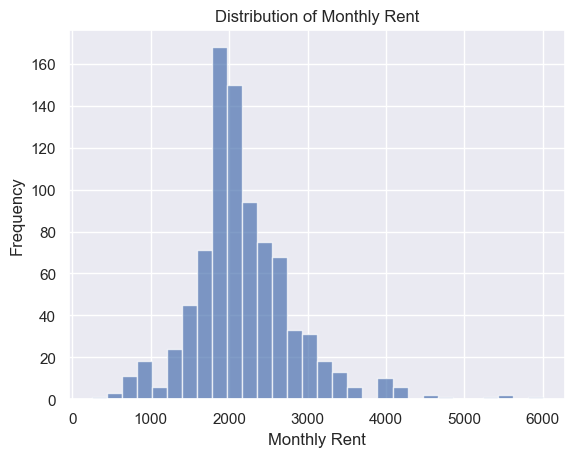

In [139]:
import matplotlib.pyplot as plt

plt.hist(cleaned_data['monthly_rent'], bins=30, alpha=0.7)
plt.title('Distribution of Monthly Rent')
plt.xlabel('Monthly Rent')
plt.ylabel('Frequency')
plt.show()

In [140]:
cleaned_data.count()

id                             858
listing_name                   858
building_name                  858
apartment_number               858
address                        858
add_lat                        827
add_long                       827
property_management_name       858
monthly_rent                   858
property_type                  858
bedroom_count                  858
bathroom_count                 858
utility_water                  858
utility_heat                   858
utility_electricity            858
utility_laundry                858
utility_wifi                   858
included_appliances            846
parking_availability           858
parking_rates                  858
parking_slots                  858
parking_distance               858
parking_restrictions           858
parking_availability_status    858
parking_address                858
pet_friendly                   858
smoking_allowed                858
apartment_size                 858
apartment_size_unit 

In [141]:
cleaned_data.isna().sum()

id                               0
listing_name                     0
building_name                    0
apartment_number                 0
address                          0
add_lat                         31
add_long                        31
property_management_name         0
monthly_rent                     0
property_type                    0
bedroom_count                    0
bathroom_count                   0
utility_water                    0
utility_heat                     0
utility_electricity              0
utility_laundry                  0
utility_wifi                     0
included_appliances             12
parking_availability             0
parking_rates                    0
parking_slots                    0
parking_distance                 0
parking_restrictions             0
parking_availability_status      0
parking_address                  0
pet_friendly                     0
smoking_allowed                  0
apartment_size                   0
apartment_size_unit 

In [142]:
columns_to_remove = [
    'id', 'listing_name', 'building_name', 'apartment_number', 'address', 
    'property_management_name', 'included_appliances', 'parking_address', 
    'apartment_size_unit', 'source', 'website', 'image', 'description', 'property_type',
    'property_image', 'load_datetime', 'is_furnished', 'availability_status', 'add_lat', 'add_long',
    'smoking_allowed', 'pet_friendly', 'parking_availability_status', 'utility_water', 'parking_restrictions', 'utility_electricity'
]

# Removing the specified columns from the DataFrame named 'data'
cleaned_data.drop(columns_to_remove, axis=1, inplace=True)

In [143]:
cleaned_data.describe()

monthly_rent  bedroom_count  bathroom_count  utility_heat  \
count    858.000000     858.000000      858.000000    858.000000   
mean    2167.717949       1.530303        1.198135      0.046620   
std      664.761346       1.010858        0.538286      0.210947   
min      250.000000      -1.000000       -1.000000      0.000000   
25%     1829.000000       1.000000        1.000000      0.000000   
50%     2030.000000       1.000000        1.000000      0.000000   
75%     2495.000000       2.000000        1.000000      0.000000   
max     6000.000000       5.000000        4.000000      1.000000   

       utility_laundry  utility_wifi  parking_availability  parking_rates  \
count       858.000000    858.000000            858.000000     858.000000   
mean          0.099068      0.002331              0.209790     210.381119   
std           0.298927      0.048252              0.407396     456.313707   
min           0.000000      0.000000              0.000000      -1.000000   
25%           0.000000      0.000000              0.000000       0.000000   
50%           0.000000      0.000000              0.000000      62.000000   
75%           0.000000      0.000000              0.000000     294.000000   
max           1.000000      1.000000              1.000000    4344.000000   

       parking_slots  parking_distance  apartment_size  dist_hospital  \
count     858.000000        858.000000      858.000000     782.000000   
mean       82.451049          7.336238      661.819347       0.541742   
std       113.011366         99.587429      572.415477       0.450390   
min        -1.000000         -1.000000       -1.000000       0.000000   
25%        10.000000          0.034633        1.000000       0.209757   
50%        29.000000          0.574614      650.000000       0.423472   
75%       144.000000          2.696030      945.000000       0.732097   
max       760.000000       1686.885726     4400.000000       2.818162   

       dist_school  dist_restaurant  dist_downtown  dist_busstop  \
count   826.000000       823.000000     858.000000    827.000000   
mean      0.393475         0.382152       9.638953      0.525179   
std       0.311948         0.299654     118.590423      0.405739   
min       0.000000         0.017888      -1.000000      0.000000   
25%       0.195277         0.185363       0.577191      0.157025   
50%       0.312417         0.325201       1.542574      0.450855   
75%       0.470973         0.482396       3.790518      0.785554   
max       3.070787         2.537209    2009.649751      2.010247   

       dist_larry_uteck_area  dist_central_halifax  dist_clayton_park  \
count             858.000000            858.000000         858.000000   
mean               12.157441              9.510131          10.004006   
std               118.039085            118.482684         118.357596   
min                -1.000000             -1.000000          -1.000000   
25%                 3.593789              1.316384           1.451788   
50%                 5.705642              1.997798           2.922394   
75%                 6.725653              2.606881           3.787417   
max              2003.140760           2007.944443        2006.392378   

       dist_rockingham  
count       858.000000  
mean         10.259790  
std         118.310401  
min          -1.000000  
25%           1.823858  
50%           3.202421  
75%           4.183364  
max        2005.875998

In [144]:
cleaned_data.isna().sum()

monthly_rent              0
bedroom_count             0
bathroom_count            0
utility_heat              0
utility_laundry           0
utility_wifi              0
parking_availability      0
parking_rates             0
parking_slots             0
parking_distance          0
apartment_size            0
lease_duration            0
dist_hospital            76
dist_school              32
dist_restaurant          35
dist_downtown             0
dist_busstop             31
dist_larry_uteck_area     0
dist_central_halifax      0
dist_clayton_park         0
dist_rockingham           0
dtype: int64

In [145]:
import numpy as np

# Calculating mean for additional columns where -1 and NaN will be replaced with the mean
for column in ['parking_rates', 'parking_slots', 'parking_distance', 'apartment_size', 'dist_busstop', 'dist_school']:
    mean_val = cleaned_data[column].replace(-1, np.nan).mean()  # Replace -1 with NaN to exclude from mean calculation
    cleaned_data[column] = cleaned_data[column].replace(-1, mean_val).fillna(mean_val)

In [146]:
median_columns = ['dist_hospital', 'dist_school', 'dist_restaurant', 'dist_busstop', 'dist_downtown', 
                  'dist_larry_uteck_area', 'dist_central_halifax', 'dist_clayton_park', 'dist_rockingham']

for column in median_columns:
    median_val = cleaned_data[column].median()
    # Replace -1 with the median value and fill NaNs with the median value using .loc
    cleaned_data.loc[cleaned_data[column] == -1, column] = median_val
    cleaned_data.loc[cleaned_data[column].isna(), column] = median_val

In [147]:
# Update bedroom_count and bathroom_count based on monthly_rent
cleaned_data.loc[cleaned_data['monthly_rent'] > 3000, ['bedroom_count', 'bathroom_count']] = [3, 2]
cleaned_data.loc[(cleaned_data['monthly_rent'] > 2500) & (cleaned_data['monthly_rent'] <= 3000), ['bedroom_count', 'bathroom_count']] = [2, 2]
cleaned_data.loc[(cleaned_data['monthly_rent'] > 1500) & (cleaned_data['monthly_rent'] <= 2500), 'bedroom_count'] = 2
cleaned_data.loc[cleaned_data['monthly_rent'] <= 1500, 'bedroom_count'] = 1

# For any remaining -1 or NaN values in bedroom_count or bathroom_count, replace with mode, using .loc for explicit indexing
for column in ['bedroom_count', 'bathroom_count']:
    mode_val = cleaned_data[column].mode()[0]  # mode() returns a Series; [0] accesses the mode value
    
    # Replace -1 with mode_val
    cleaned_data.loc[cleaned_data[column] == -1, column] = mode_val
    
    # Fill NaN values with mode_val
    cleaned_data.loc[cleaned_data[column].isnull(), column] = mode_val

In [148]:
cleaned_data.isna().sum()

monthly_rent             0
bedroom_count            0
bathroom_count           0
utility_heat             0
utility_laundry          0
utility_wifi             0
parking_availability     0
parking_rates            0
parking_slots            0
parking_distance         0
apartment_size           0
lease_duration           0
dist_hospital            0
dist_school              0
dist_restaurant          0
dist_downtown            0
dist_busstop             0
dist_larry_uteck_area    0
dist_central_halifax     0
dist_clayton_park        0
dist_rockingham          0
dtype: int64

In [149]:
cleaned_data.describe()

monthly_rent  bedroom_count  bathroom_count  utility_heat  \
count    858.000000     858.000000      858.000000    858.000000   
mean    2167.717949       1.969697        1.293706      0.046620   
std      664.761346       0.431020        0.483069      0.210947   
min      250.000000       1.000000        0.000000      0.000000   
25%     1829.000000       2.000000        1.000000      0.000000   
50%     2030.000000       2.000000        1.000000      0.000000   
75%     2495.000000       2.000000        2.000000      0.000000   
max     6000.000000       3.000000        4.000000      1.000000   

       utility_laundry  utility_wifi  parking_availability  parking_rates  \
count       858.000000    858.000000            858.000000     858.000000   
mean          0.099068      0.002331              0.209790     275.893130   
std           0.298927      0.048252              0.407396     440.860565   
min           0.000000      0.000000              0.000000       0.000000   
25%           0.000000      0.000000              0.000000      62.000000   
50%           0.000000      0.000000              0.000000     275.893130   
75%           0.000000      0.000000              0.000000     294.000000   
max           1.000000      1.000000              1.000000    4344.000000   

       parking_slots  parking_distance  apartment_size  dist_hospital  \
count     858.000000        858.000000      858.000000     858.000000   
mean      108.314504          9.919836      876.621914       0.531266   
std       103.008339         99.479111      430.253471       0.431268   
min        10.000000          0.000000        1.000000       0.000000   
25%        29.000000          0.523736      650.000000       0.219205   
50%       108.314504          2.547554      876.621914       0.423472   
75%       144.000000          9.827861      945.000000       0.658759   
max       760.000000       1686.885726     4400.000000       2.818162   

       dist_school  dist_restaurant  dist_downtown  dist_busstop  \
count   858.000000       858.000000     858.000000    858.000000   
mean      0.393475         0.379828       9.730818      0.525179   
std       0.306069         0.293688     118.583122      0.398333   
min       0.000000         0.017888       0.125834      0.000000   
25%       0.205823         0.194166       0.675749      0.165158   
50%       0.326700         0.325201       1.542574      0.474221   
75%       0.456891         0.482396       3.790518      0.760496   
max       3.070787         2.537209    2009.649751      2.010247   

       dist_larry_uteck_area  dist_central_halifax  dist_clayton_park  \
count             858.000000            858.000000         858.000000   
mean               12.399719              9.618443          10.145724   
std               118.018687            118.474386         118.346671   
min                 0.136627              0.278459           0.128768   
25%                 3.880477              1.417401           1.871489   
50%                 5.706937              1.997798           2.924700   
75%                 6.725653              2.606881           3.787417   
max              2003.140760           2007.944443        2006.392378   

       dist_rockingham  
count       858.000000  
mean         10.411626  
std         118.298535  
min           0.271616  
25%           2.111032  
50%           3.202487  
75%           4.183364  
max        2005.875998

### EDA

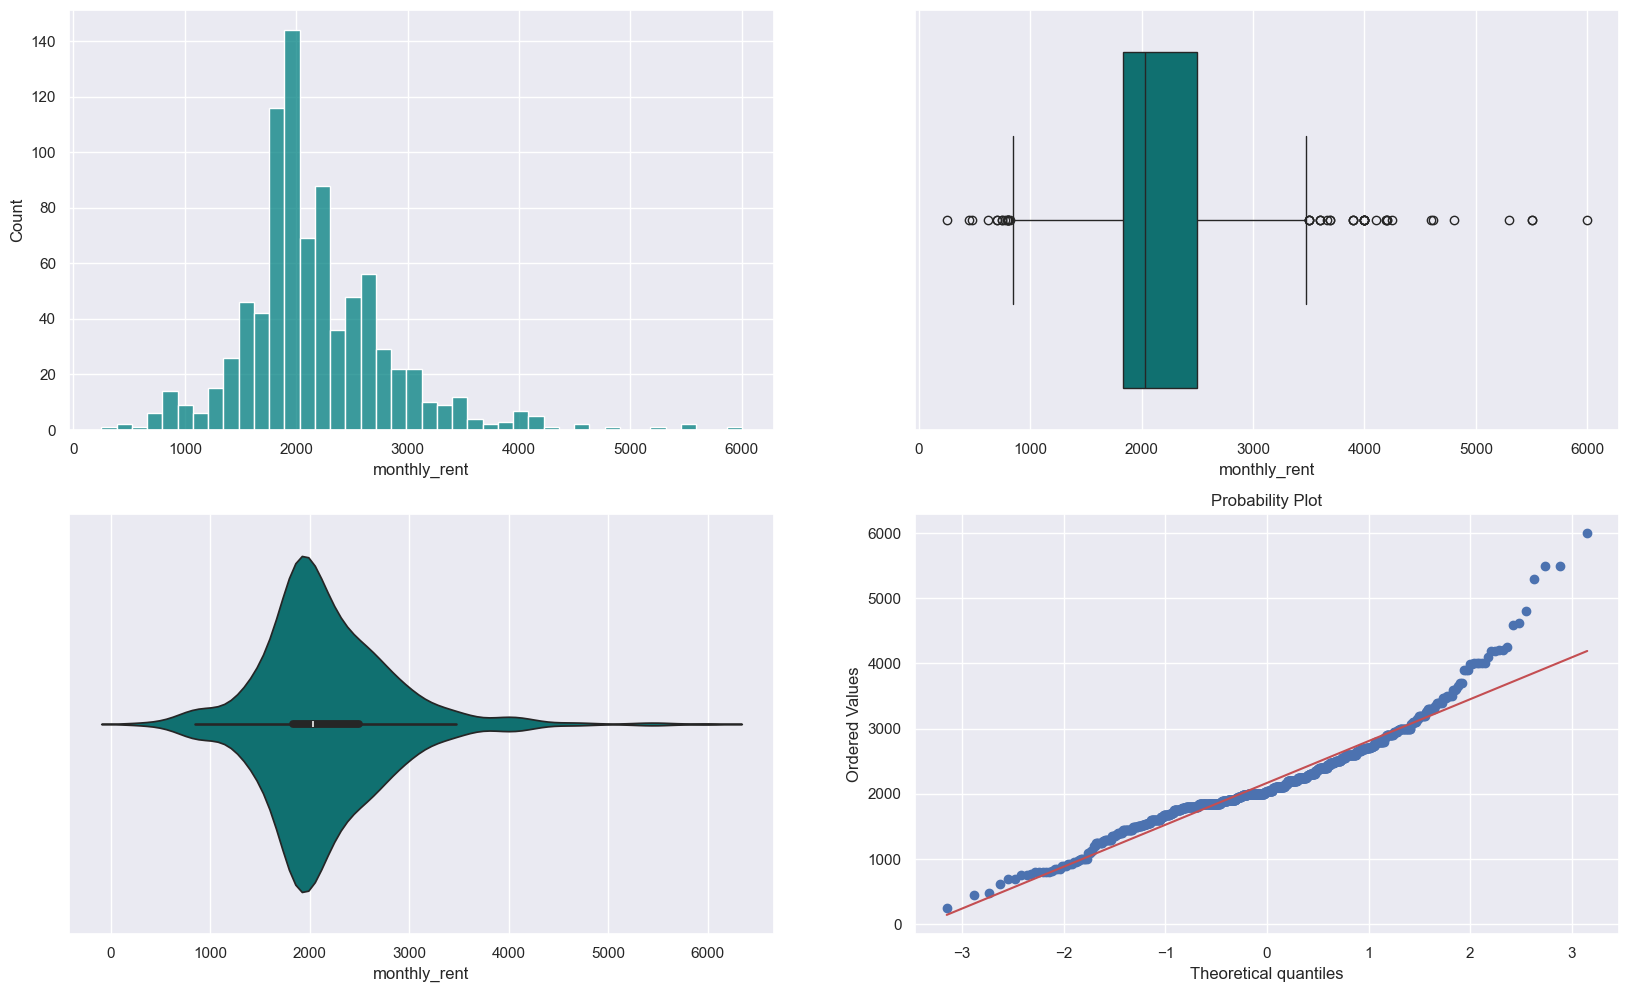

In [150]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import probplot
import pylab

fig, ax = plt.subplots(2, 2, figsize=(20, 12))

# Using cleaned_data for the plots
ax1 = sns.histplot(x=cleaned_data['monthly_rent'], color='teal', ax=ax[0, 0])
ax2 = sns.boxplot(x=cleaned_data['monthly_rent'], ax=ax[0, 1], color= 'teal')
ax3 = sns.violinplot(x=cleaned_data['monthly_rent'], ax=ax[1, 0], color= 'teal')
ax4 = probplot(cleaned_data['monthly_rent'], plot=pylab)

pylab.show()

In [151]:
import pandas as pd

# Assuming 'data' is your DataFrame and 'monthly_rent' is the column you're examining

# Calculate Q1 (25th percentile) and Q3 (75th percentile) of the monthly_rent column
Q1 = cleaned_data['monthly_rent'].quantile(0.25)
Q3 = cleaned_data['monthly_rent'].quantile(0.75)

# Calculate the Interquartile Range (IQR)
IQR = Q3 - Q1

# Define the criteria for an outlier
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print(f"Original data had {len(cleaned_data)} rows.")

# Filter out outliers and retain only the valid data points within the IQR bounds
cleaned_data = cleaned_data[(cleaned_data['monthly_rent'] >= lower_bound) & (cleaned_data['monthly_rent'] <= upper_bound)]

print(f"After removing outliers, data has {len(cleaned_data)} rows.")

Original data had 858 rows.
After removing outliers, data has 810 rows.


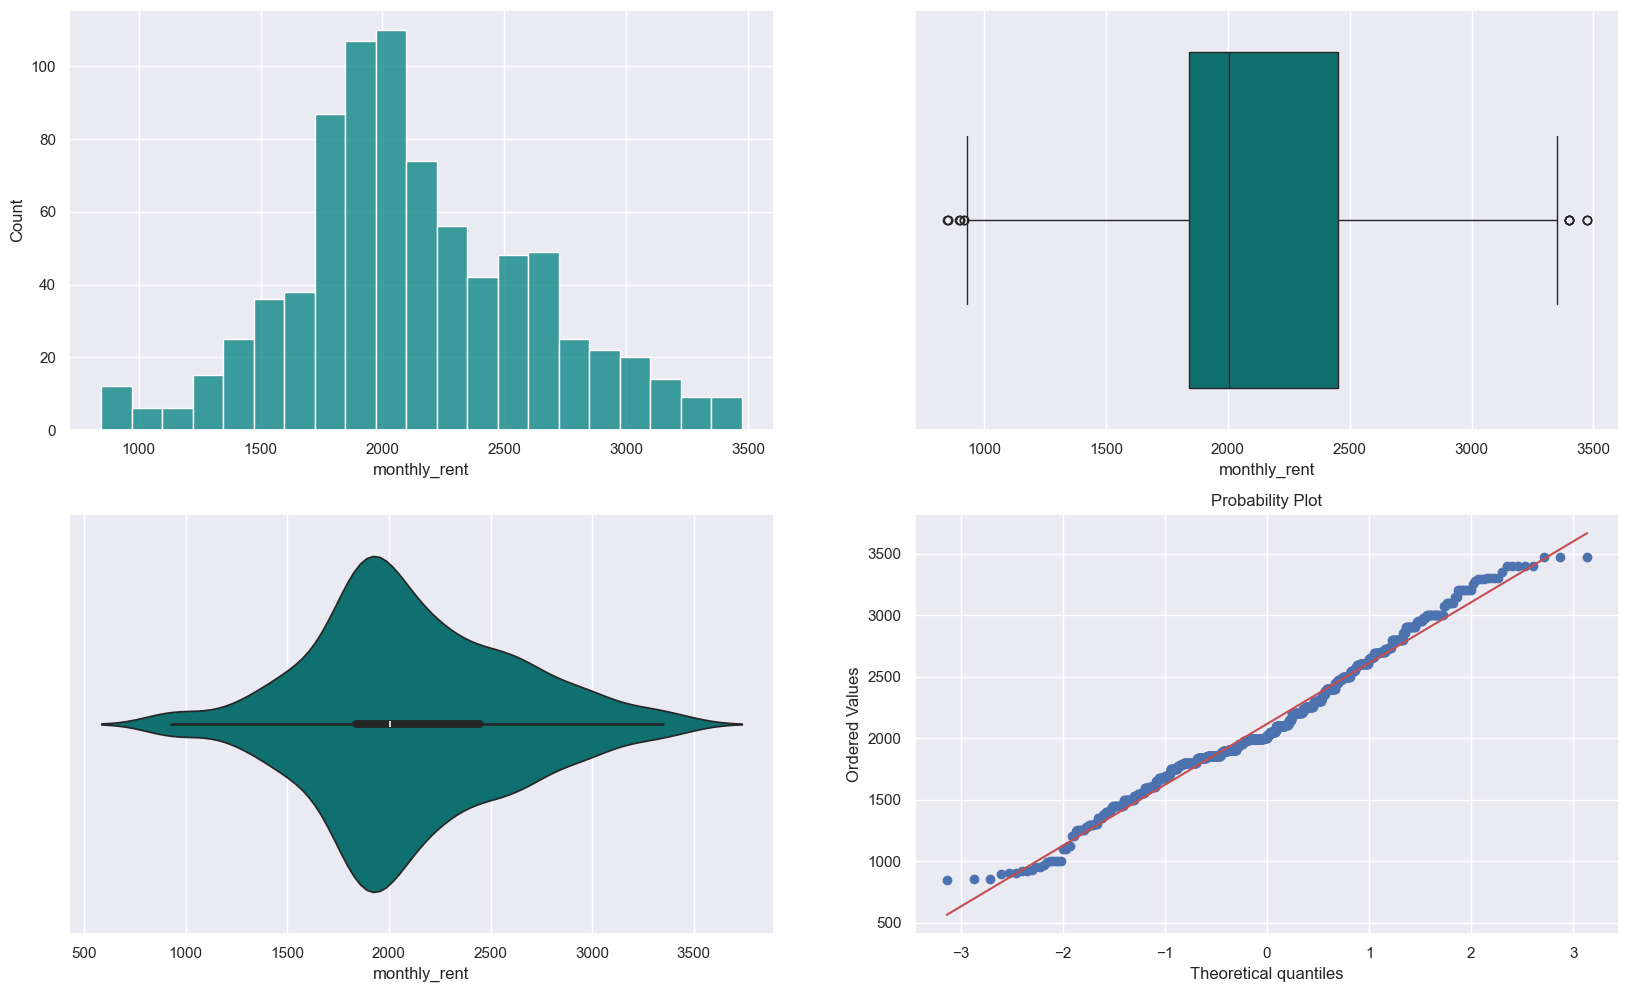

In [152]:
fig, ax = plt.subplots(2, 2, figsize=(20, 12))
ax1 = sns.histplot(x = cleaned_data['monthly_rent'], color='teal', ax= ax[0, 0])
ax2 = sns.boxplot(x = cleaned_data['monthly_rent'], ax= ax[0, 1], color= 'teal')
ax3 = sns.violinplot(x = cleaned_data['monthly_rent'], ax= ax[1, 0], color= 'teal')
ax4 = probplot(cleaned_data['monthly_rent'], plot=pylab)
pylab.show()

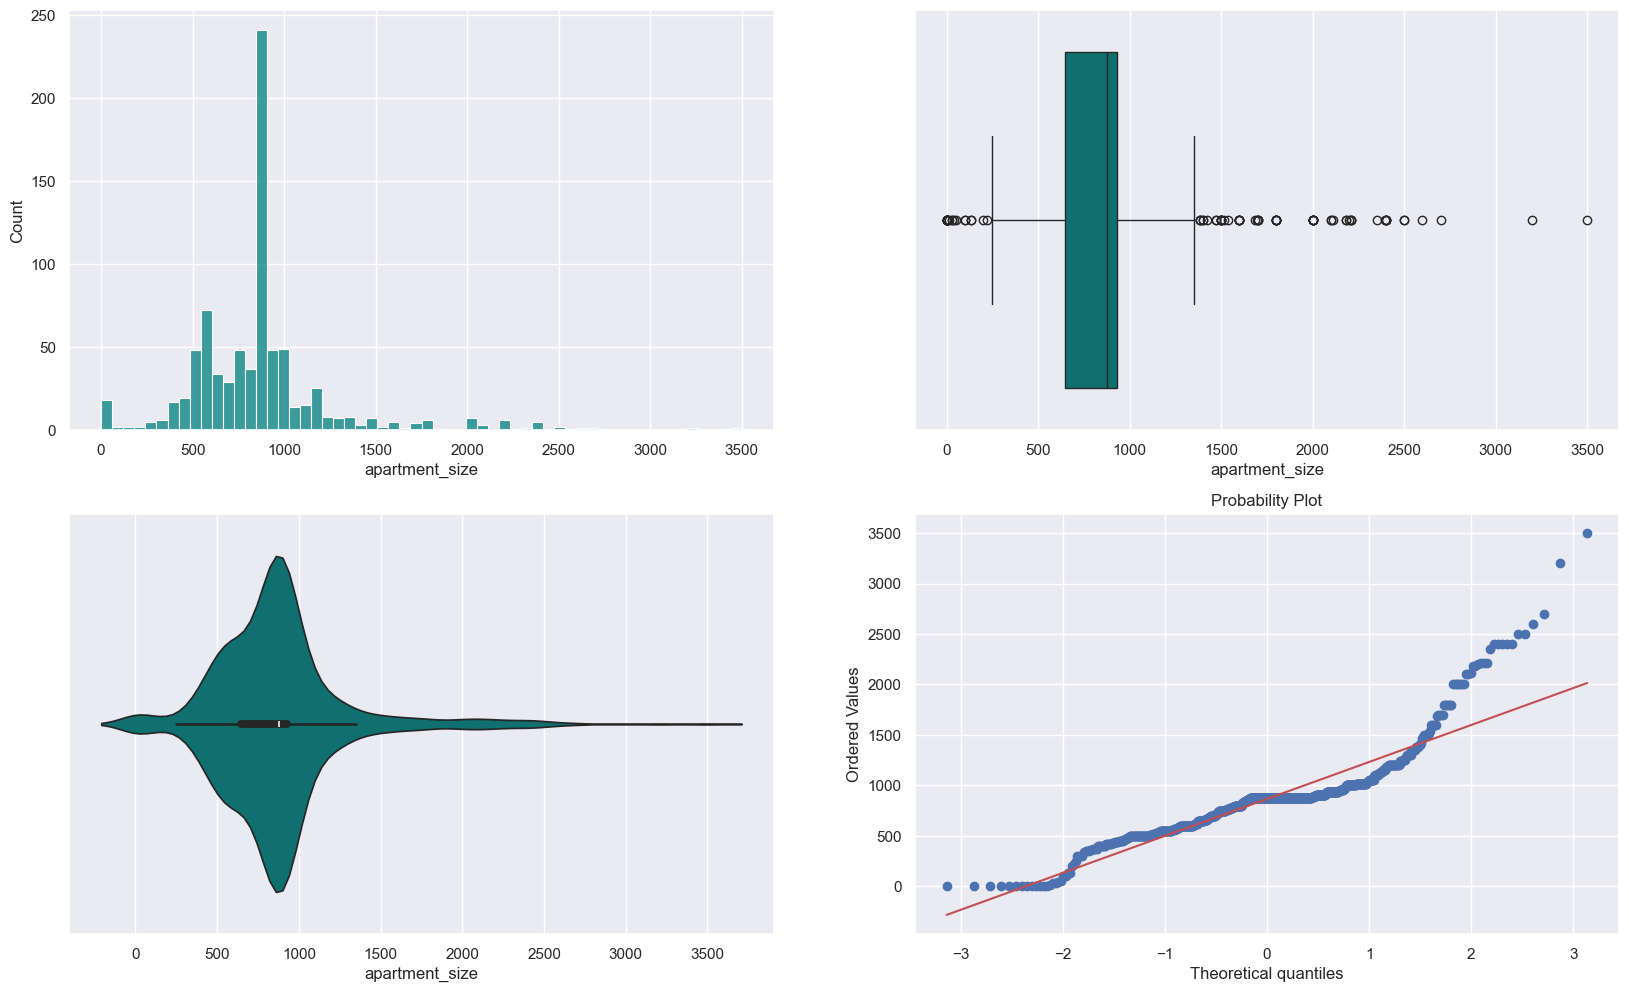

In [153]:
fig, ax = plt.subplots(2, 2, figsize=(20, 12))
ax1 = sns.histplot(x = cleaned_data['apartment_size'], color='teal', ax= ax[0, 0])
ax2 = sns.boxplot(x = cleaned_data['apartment_size'], ax= ax[0, 1], color= 'teal')
ax3 = sns.violinplot(x = cleaned_data['apartment_size'], ax= ax[1, 0], color= 'teal')
ax4 = probplot(cleaned_data['apartment_size'], plot=pylab)
pylab.show()

In [154]:
import numpy as np

# Example logic to update apartment_size
def calculate_new_size(row):
    base_size = (row['bedroom_count'] + row['bathroom_count']) * 250
    rent_proportion = row['monthly_rent'] / 100
    return base_size + rent_proportion

# Apply the custom logic to rows where apartment_size is below 500
cleaned_data.loc[cleaned_data['apartment_size'] < 500, 'apartment_size'] = cleaned_data.apply(lambda row: calculate_new_size(row) if row['apartment_size'] < 500 else row['apartment_size'], axis=1)

# Ensure no apartment_size is unrealistically low after the update
cleaned_data['apartment_size'] = np.maximum(cleaned_data['apartment_size'], 500)

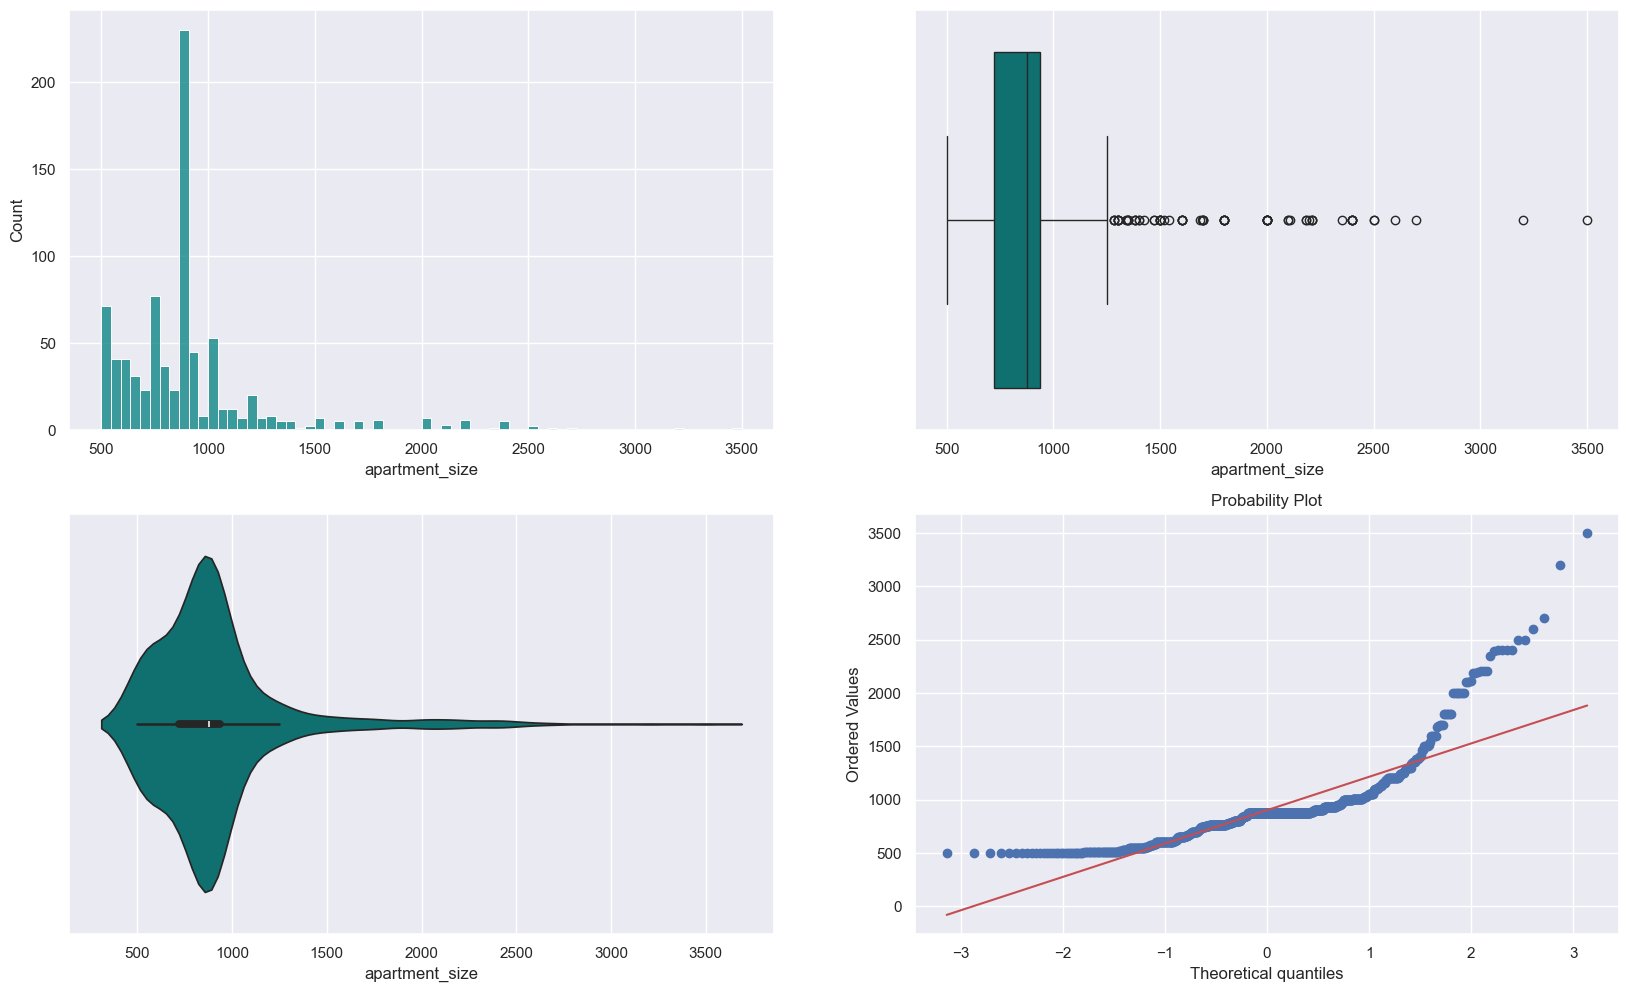

In [155]:
fig, ax = plt.subplots(2, 2, figsize=(20, 12))
ax1 = sns.histplot(x = cleaned_data['apartment_size'], color='teal', ax= ax[0, 0])
ax2 = sns.boxplot(x = cleaned_data['apartment_size'], ax= ax[0, 1], color= 'teal')
ax3 = sns.violinplot(x = cleaned_data['apartment_size'], ax= ax[1, 0], color= 'teal')
ax4 = probplot(cleaned_data['apartment_size'], plot=pylab)
pylab.show()

In [156]:
# Calculate the minimum distance
cleaned_data['min_distance'] = cleaned_data[['dist_larry_uteck_area', 'dist_central_halifax', 
                             'dist_clayton_park', 'dist_rockingham']].min(axis=1)

# Conditions for selecting area based on the minimum distance
conditions = [
    (cleaned_data['min_distance'] == cleaned_data['dist_larry_uteck_area']),
    (cleaned_data['min_distance'] == cleaned_data['dist_central_halifax']),
    (cleaned_data['min_distance'] == cleaned_data['dist_clayton_park']),
    (cleaned_data['min_distance'] == cleaned_data['dist_rockingham'])
]

# Area names corresponding to each condition
choices = ['Uteck Area', 'Central Halifax', 'Clayton Park', 'Rockingham']

# Create the new 'area' column based on the conditions and choices
cleaned_data['location'] = np.select(conditions, choices, default='Unknown')

/var/folders/z6/yb_00mr541q1fbtlygsbgk6m0000gn/T/ipykernel_21849/286817777.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(x=cleaned_data['location'],
/var/folders/z6/yb_00mr541q1fbtlygsbgk6m0000gn/T/ipykernel_21849/286817777.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=cleaned_data['location'],


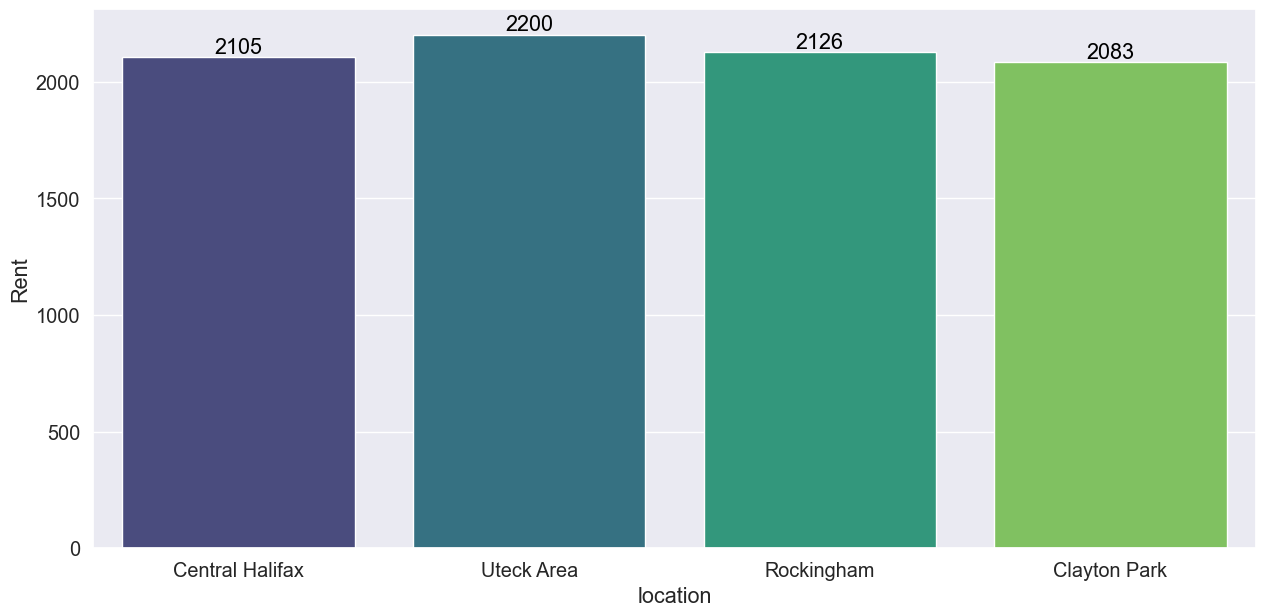

In [157]:
sns.set_context('notebook', font_scale = 1.3)
plt.figure(figsize=(15, 7))
ax = sns.barplot(x=cleaned_data['location'], 
                 y=cleaned_data['monthly_rent'], 
                 palette='viridis',
                 ci = None)
plt.ylabel('Rent');

for p in ax.patches:
    ax.annotate(int(p.get_height()), (p.get_x() + 0.4, p.get_height() + 1), ha = 'center', va = 'bottom', color = 'Black')

In [158]:
location_counts = cleaned_data['location'].value_counts()

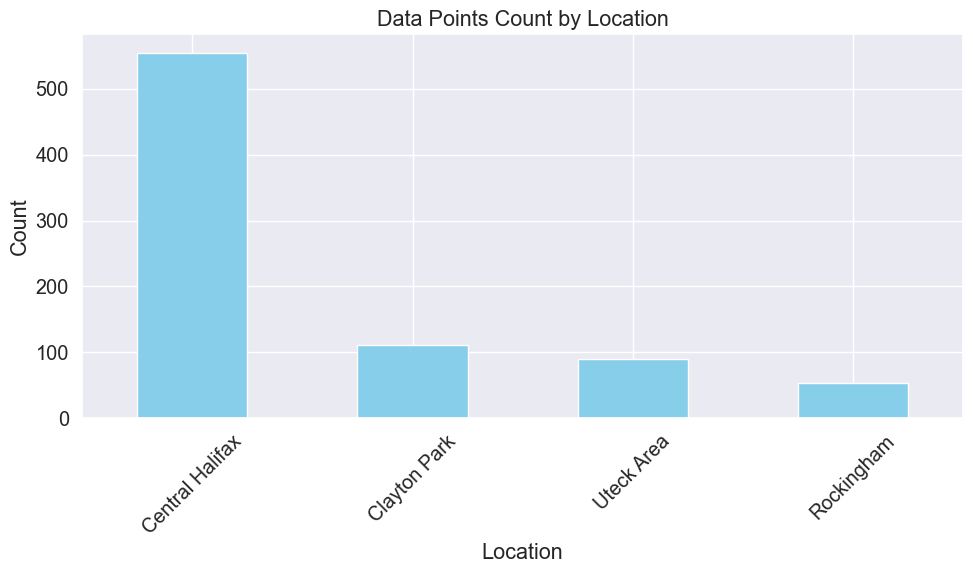

In [159]:
import matplotlib.pyplot as plt

# Plotting the counts as a bar chart
location_counts.plot(kind='bar', figsize=(10, 6), color='skyblue')

plt.title('Data Points Count by Location')
plt.xlabel('Location')
plt.ylabel('Count')
plt.xticks(rotation=45)  # Rotate labels to avoid overlapping
plt.tight_layout()  # Adjust layout to make room for the rotated x-axis labels

# Show the plot
plt.show()


/var/folders/z6/yb_00mr541q1fbtlygsbgk6m0000gn/T/ipykernel_21849/1223966285.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(x=cleaned_data['bedroom_count'].sort_values(ascending=True),
/var/folders/z6/yb_00mr541q1fbtlygsbgk6m0000gn/T/ipykernel_21849/1223966285.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=cleaned_data['bedroom_count'].sort_values(ascending=True),


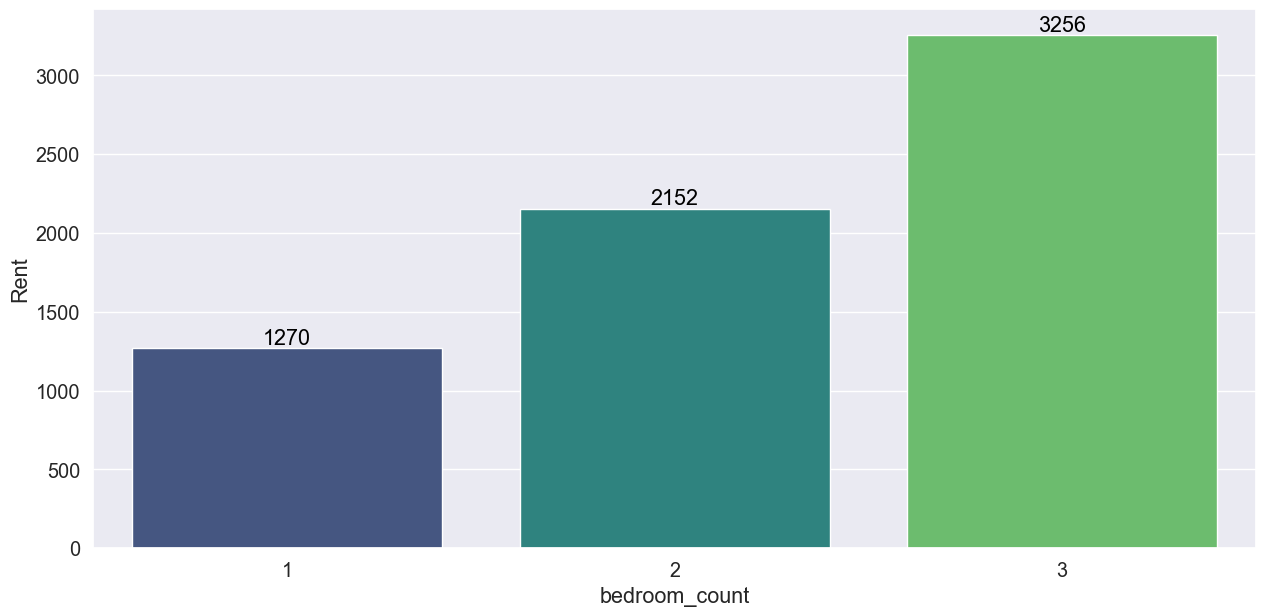

In [160]:
sns.set_context('notebook', font_scale = 1.3)
plt.figure(figsize=(15, 7))
ax = sns.barplot(x=cleaned_data['bedroom_count'].sort_values(ascending=True), 
                 y=cleaned_data['monthly_rent'], 
                 palette='viridis',
                 ci = None)
plt.ylabel('Rent');

for p in ax.patches:
    ax.annotate(int(p.get_height()), (p.get_x() + 0.4, p.get_height() + 1), ha = 'center', va = 'bottom', color = 'Black')

In [161]:
cleaned_data.columns

Index(['monthly_rent', 'bedroom_count', 'bathroom_count', 'utility_heat',
       'utility_laundry', 'utility_wifi', 'parking_availability',
       'parking_rates', 'parking_slots', 'parking_distance', 'apartment_size',
       'lease_duration', 'dist_hospital', 'dist_school', 'dist_restaurant',
       'dist_downtown', 'dist_busstop', 'dist_larry_uteck_area',
       'dist_central_halifax', 'dist_clayton_park', 'dist_rockingham',
       'min_distance', 'location'],
      dtype='object')

In [162]:
cleaned_data = pd.get_dummies(cleaned_data, columns=['location'])

In [163]:
cleaned_data.columns

Index(['monthly_rent', 'bedroom_count', 'bathroom_count', 'utility_heat',
       'utility_laundry', 'utility_wifi', 'parking_availability',
       'parking_rates', 'parking_slots', 'parking_distance', 'apartment_size',
       'lease_duration', 'dist_hospital', 'dist_school', 'dist_restaurant',
       'dist_downtown', 'dist_busstop', 'dist_larry_uteck_area',
       'dist_central_halifax', 'dist_clayton_park', 'dist_rockingham',
       'min_distance', 'location_Central Halifax', 'location_Clayton Park',
       'location_Rockingham', 'location_Uteck Area'],
      dtype='object')

In [164]:
columns_to_remove = [
    'lease_duration', 'dist_larry_uteck_area', 'dist_central_halifax', 'dist_clayton_park', 'dist_rockingham', 'min_distance'
]

# Removing the specified columns from the DataFrame named 'data'
cleaned_data.drop(columns_to_remove, axis=1, inplace=True)

In [165]:
# List of boolean columns to convert
bool_columns = ['location_Central Halifax', 'location_Clayton Park', 'location_Rockingham', 'location_Uteck Area'] 

# Convert each column in 'bool_columns' list to int
for column in bool_columns:
    cleaned_data[column] = cleaned_data[column].astype(int)

In [166]:
cleaned_data.head()

monthly_rent  bedroom_count  bathroom_count  utility_heat  utility_laundry  \
1        2750.0              2               2             0                0   
2        2110.0              2               1             0                1   
3        2640.0              2               2             0                1   
4        2250.0              2               1             0                0   
5        2029.0              2               1             0                0   

   utility_wifi  parking_availability  parking_rates  parking_slots  \
1             0                     0          150.0          150.0   
2             0                     0          101.0           79.0   
3             0                     0          101.0           79.0   
4             0                     0          294.0           10.0   
5             0                     0          280.0          240.0   

   parking_distance  apartment_size  dist_hospital  dist_school  \
1          1.322786      876.621914       0.257685     1.136112   
2          0.168282      614.000000       0.171352     0.260229   
3          0.168282      830.000000       0.171352     0.260229   
4          2.384033      876.621914       0.986496     0.373647   
5          0.198214      507.000000       0.436513     0.285239   

   dist_restaurant  dist_downtown  dist_busstop  location_Central Halifax  \
1         0.575778       1.657141      1.238049                         1   
2         0.126655       0.361111      0.091678                         1   
3         0.126655       0.361111      0.091678                         1   
4         0.736691       3.284001      0.921467                         1   
5         0.100903       0.268248      0.111591                         1   

   location_Clayton Park  location_Rockingham  location_Uteck Area  
1                      0                    0                    0  
2                      0                    0                    0  
3                      0                    0                    0  
4                      0                    0                    0  
5                      0                    0                    0

In [167]:
print(f'Number of rows in the dataset: {cleaned_data.shape[0]}')
print(f'Number of columns in the dataset: {cleaned_data.shape[1]}')

Number of rows in the dataset: 810
Number of columns in the dataset: 20


In [168]:
cleaned_data.describe()

monthly_rent  bedroom_count  bathroom_count  utility_heat  \
count    810.000000     810.000000      810.000000    810.000000   
mean    2114.358025       1.945679        1.266667      0.048148   
std      497.665053       0.368087        0.466955      0.214211   
min      846.000000       1.000000        0.000000      0.000000   
25%     1839.000000       2.000000        1.000000      0.000000   
50%     2004.000000       2.000000        1.000000      0.000000   
75%     2450.000000       2.000000        2.000000      0.000000   
max     3475.000000       3.000000        4.000000      1.000000   

       utility_laundry  utility_wifi  parking_availability  parking_rates  \
count       810.000000    810.000000            810.000000     810.000000   
mean          0.103704      0.002469              0.217284     269.811045   
std           0.305064      0.049660              0.412652     417.827016   
min           0.000000      0.000000              0.000000       0.000000   
25%           0.000000      0.000000              0.000000      62.000000   
50%           0.000000      0.000000              0.000000     275.893130   
75%           0.000000      0.000000              0.000000     294.000000   
max           1.000000      1.000000              1.000000    2900.000000   

       parking_slots  parking_distance  apartment_size  dist_hospital  \
count     810.000000        810.000000      810.000000     810.000000   
mean      107.086367          8.260538      902.662636       0.532241   
std       100.585255         83.669064      361.567396       0.430829   
min        10.000000          0.000000      500.000000       0.000000   
25%        29.000000          0.569241      720.000000       0.226458   
50%       108.314504          2.613324      876.621914       0.423472   
75%       144.000000          9.919836      935.000000       0.667226   
max       760.000000       1686.885726     3500.000000       2.818162   

       dist_school  dist_restaurant  dist_downtown  dist_busstop  \
count   810.000000       810.000000     810.000000    810.000000   
mean      0.387844         0.376075       7.673126      0.524879   
std       0.287549         0.282337      99.721827      0.398252   
min       0.000000         0.017888       0.125834      0.000000   
25%       0.203654         0.195206       0.682423      0.165158   
50%       0.326010         0.325201       1.545051      0.472249   
75%       0.446959         0.482396       3.790518      0.743510   
max       2.978673         2.537209    2009.649751      2.010247   

       location_Central Halifax  location_Clayton Park  location_Rockingham  \
count                810.000000             810.000000           810.000000   
mean                   0.685185               0.137037             0.066667   
std                    0.464729               0.344099             0.249598   
min                    0.000000               0.000000             0.000000   
25%                    0.000000               0.000000             0.000000   
50%                    1.000000               0.000000             0.000000   
75%                    1.000000               0.000000             0.000000   
max                    1.000000               1.000000             1.000000   

       location_Uteck Area  
count           810.000000  
mean              0.111111  
std               0.314464  
min               0.000000  
25%               0.000000  
50%               0.000000  
75%               0.000000  
max               1.000000

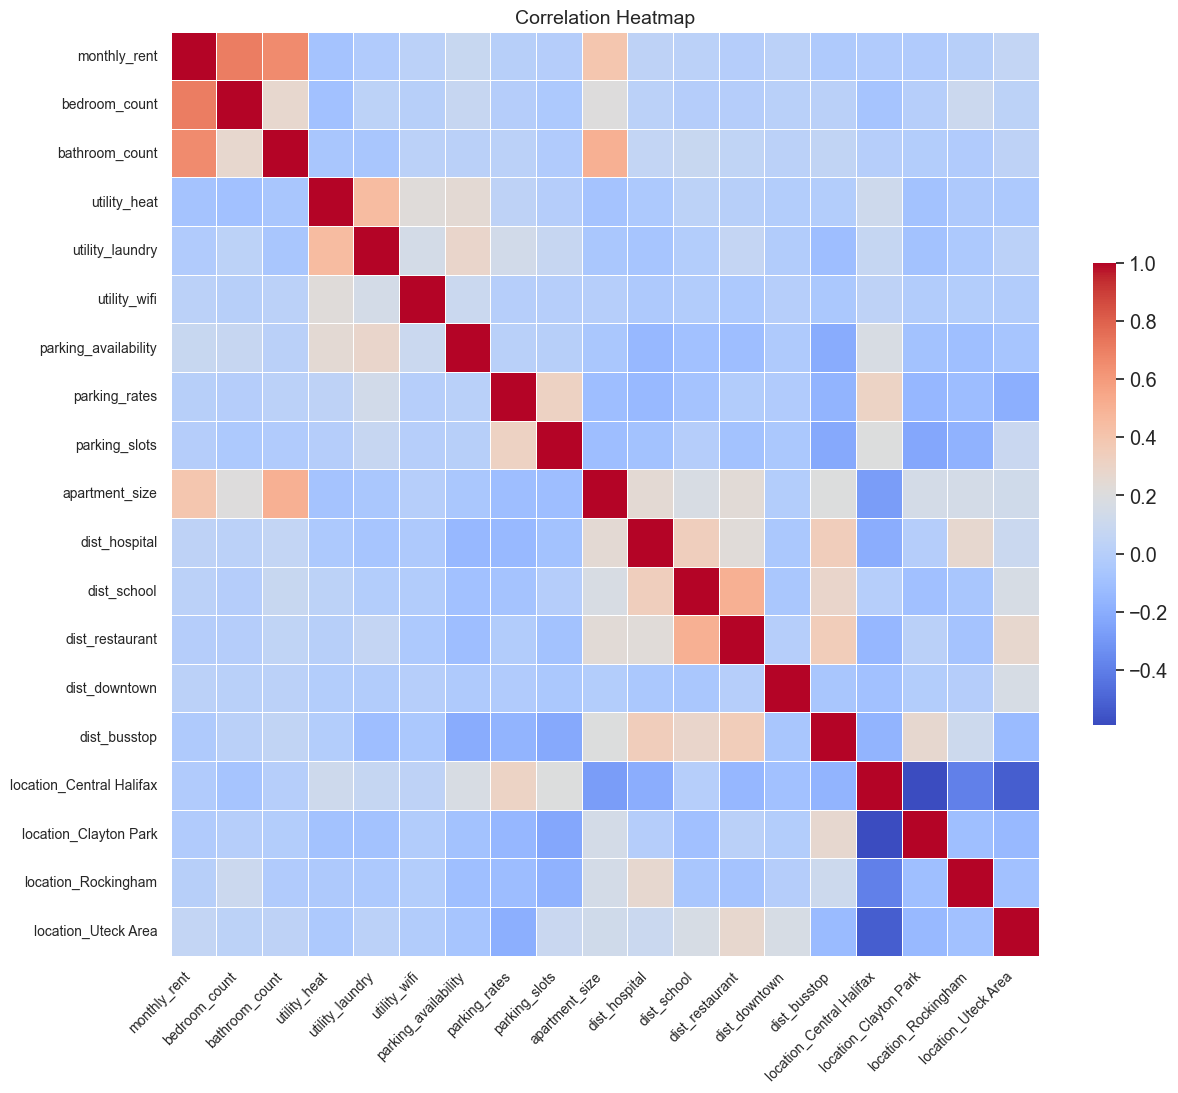

In [173]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the correlation matrix after dropping 'parking_distance'
corr = cleaned_data.drop('parking_distance', axis=1).corr()

# Increase figure size for generating the heatmap
plt.figure(figsize=(14, 12))

# Create the heatmap
sns.heatmap(corr, 
            xticklabels=corr.columns, 
            yticklabels=corr.columns, 
            cmap='coolwarm', 
            annot=False,  # Consider turning off annotations for clarity
            linewidths=.5,  # Adds space between cells
            cbar_kws={"shrink": .5},  # Optionally shrink the color bar
            fmt=".2f")

# Improve the readability of the labels
plt.xticks(rotation=45, ha="right", fontsize=10)  # Rotate x labels for better fit and adjust font size
plt.yticks(fontsize=10)  # Adjust y labels font size
plt.title('Correlation Heatmap', fontsize=14)  # Title with adjusted font size

# Save the figure
plt.savefig('correlation_heatmap.png', bbox_inches='tight', dpi=300)
# 'bbox_inches='tight'' minimizes the margin around the figure
# 'dpi=300' sets a high resolution suitable for printing

plt.show()


## Modelling

In [105]:
y = cleaned_data['monthly_rent']
X = cleaned_data.drop('monthly_rent', axis= 1)

# bc_result = boxcox(y)
# y_boxcox = bc_result[0]
# lambda_ = bc_result[1]
# print(f"bc_result: {bc_result}")
# print(f"y_boxcox: {y_boxcox}")
# print(f"lambda_: {lambda_}")

In [106]:
# X_train, X_test, y_train, y_test = train_test_split(X, y_boxcox, test_size= 0.2, random_state = 42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state = 42)

In [107]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [108]:
X_train.shape

(648, 19)

In [109]:
X_test.shape

(162, 19)

In [110]:
models = {
    'ridge' : Ridge(),
    'xgboost' : XGBRegressor(),
    'catboost' : CatBoostRegressor(verbose=0),
    'gradient boosting' : GradientBoostingRegressor(),
    'lasso' : Lasso(),
    'random forest' : RandomForestRegressor(),
    'bayesian ridge' : BayesianRidge(),
    'support vector': SVR()G,V
}

In [111]:
for name, model in models.items():
    model.fit(X_train, y_train)
    print(f'{name} trained')

ridge trained
xgboost trained
catboost trained
gradient boosting trained
lasso trained
random forest trained
bayesian ridge trained
support vector trained


In [112]:
model = tf.keras.Sequential()

model.add(tf.keras.layers.Dense(20))
model.add(tf.keras.layers.Dense(60))
model.add(tf.keras.layers.Dense(60))
model.add(tf.keras.layers.Dense(1))

model.compile(
    loss = 'mse', 
    optimizer = tf.keras.optimizers.Adam(), 
    metrics = [tf.keras.metrics.RootMeanSquaredError(name='rmse')]
)

model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=5)

Epoch 1/5
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 4790753.0000 - rmse: 2189.3899 - val_loss: 4488133.5000 - val_rmse: 2145.8682
Epoch 2/5
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4778379.0000 - rmse: 2185.6711 - val_loss: 4467533.5000 - val_rmse: 2140.8735
Epoch 3/5
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4707423.5000 - rmse: 2169.5811 - val_loss: 4356708.5000 - val_rmse: 2114.8745
Epoch 4/5
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4408407.5000 - rmse: 2099.4619 - val_loss: 3907827.2500 - val_rmse: 2002.8873
Epoch 5/5
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3981502.7500 - rmse: 1995.2167 - val_loss: 2970373.2500 - val_rmse: 1746.3755


In [113]:
RMSE_ann = model.evaluate(X_test, y_test)[1]
RMSE_ann

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 605us/step - loss: 3037399.7500 - rmse: 1749.2288


1746.37548828125

### Evaluation

In [114]:
import numpy as np
from sklearn.metrics import mean_squared_error

y_train_mean = np.mean(y_train)
baseline_predictions = np.full(shape=y_train.shape, fill_value=y_train_mean)
baseline_rmse = np.sqrt(mean_squared_error(y_train, baseline_predictions))
print(f"Baseline Model RMSE on Training Data: {baseline_rmse}")

Baseline Model RMSE on Training Data: 503.55056325366814


In [115]:
results = {}
kf = KFold(n_splits= 10)

for name, model in models.items():
    result = np.mean(np.sqrt(-cross_val_score(model, X_train, y_train, scoring = 'neg_mean_squared_error', cv= kf)))
    results[name] = result
    
results['ANN'] = RMSE_ann

In [116]:
for name, result in results.items():
    print(f"{name} : {round(result, 3)}")

ridge : 316.886
xgboost : 186.289
catboost : 186.419
gradient boosting : 185.215
lasso : 252.184
random forest : 181.253
bayesian ridge : 257.869
support vector : 504.122
ANN : 1746.375


In [117]:
results_df = pd.DataFrame(results, index=range(0,1)).T.rename(columns={0: 'RMSE'}).sort_values('RMSE', ascending=False)
results_df.T

ANN  support vector       ridge  bayesian ridge       lasso  \
RMSE  1746.375488      504.121843  316.886104      257.869196  252.184347   

        catboost     xgboost  gradient boosting  random forest  
RMSE  186.418954  186.289143         185.214954     181.253007

/var/folders/z6/yb_00mr541q1fbtlygsbgk6m0000gn/T/ipykernel_21849/29923109.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x= results_df.index, y = results_df['RMSE'], palette = 'winter')


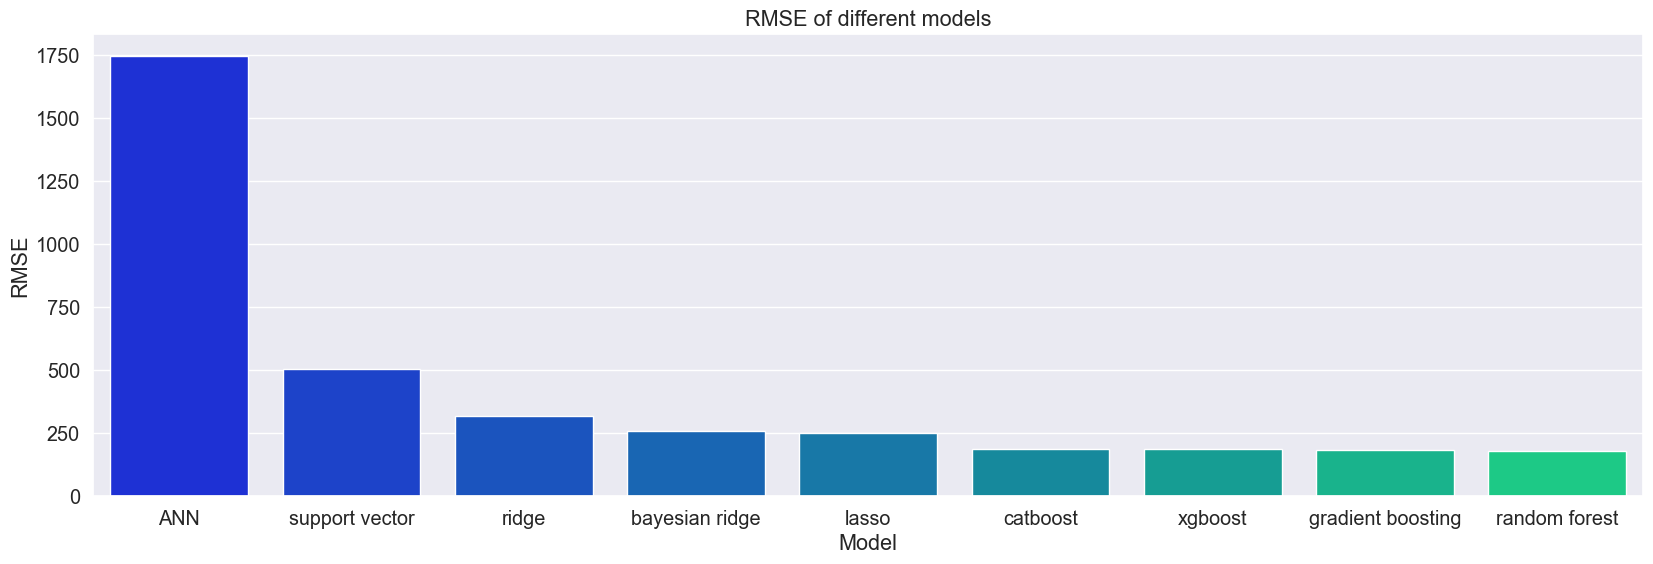

In [118]:
plt.figure(figsize = (20, 6))
sns.barplot(x= results_df.index, y = results_df['RMSE'], palette = 'winter')
plt.xlabel('Model')
plt.ylabel('RMSE')
plt.title('RMSE of different models');

In [124]:
weights = {
    'randomforest': 1 / 181.253,
    'gradboost': 1 / 185.215,
    'xgboost': 1 / 186.289,
    'catboost': 1 / 186.419,
    'lasso': 1 / 252.184
}

# Normalize weights so they sum to 1
total = sum(weights.values())
normalized_weights = {k: v / total for k, v in weights.items()}

In [125]:
for model_key, normalized_weight in normalized_weights.items():
    print(f"Model Key: {model_key} and normalized weight: {normalized_weight}")

Model Key: randomforest and normalized weight: 0.2153966954478292
Model Key: gradboost and normalized weight: 0.21078906805607203
Model Key: xgboost and normalized weight: 0.20957381938818384
Model Key: catboost and normalized weight: 0.209427672286652
Model Key: lasso and normalized weight: 0.15481274482126295


In [126]:
final_predictions = (
    0.2153966954478292 * models['random forest'].predict(X_test) + 
    0.21078906805607203 * models['gradient boosting'].predict(X_test) + 
    0.20957381938818384 * models['xgboost'].predict(X_test) +
    0.209427672286652 * models['catboost'].predict(X_test) +
    0.15481274482126295 * models['lasso'].predict(X_test)
)

In [127]:
print(f'RMSE: {np.sqrt(mean_squared_error(y_test, final_predictions))}')
print(f'R-square: {r2_score(y_test, final_predictions)}')

RMSE: 182.02016642544802
R-square: 0.8508326645290599


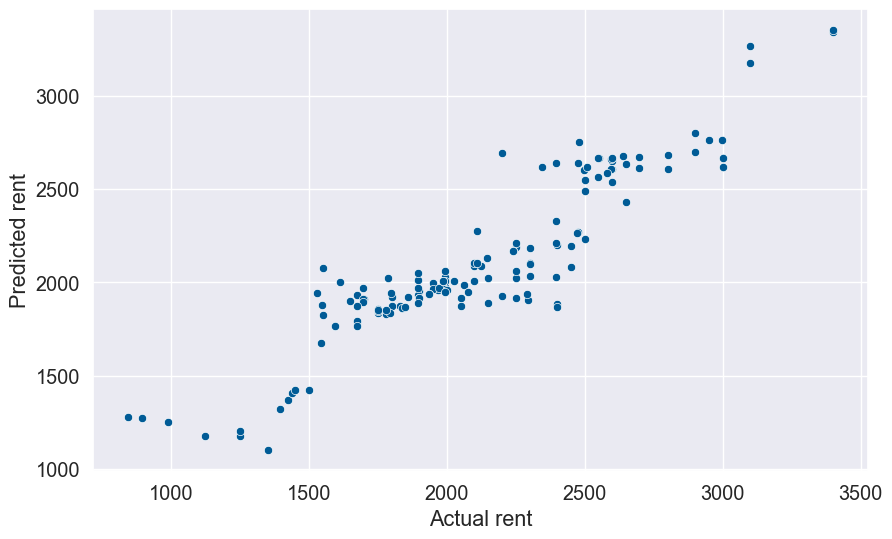

In [128]:
plt.figure(figsize= (10, 6))
sns.scatterplot(x= y_test, y= final_predictions, color= '#005b96')
plt.xlabel('Actual rent')
plt.ylabel('Predicted rent')
plt.show()